# Exploratory Data Analysis

# Brian Hockett, Conor Gibbons, Kalenga Mumba, Ian Kariuki

## Audience/Stakeholders

**Clearly identify who your are writing your final report for**

This final report on the physical performance of the UVA Men's Basketball team is intended for the Coaching Staff, as well as the Athletic Department. These stakeholders are involved in studying and making decisions about player development, training load, game preparation, and long-term performance strategy, as well as high school and transfer student recruitment/scouting.

## Problem Statement

**Create a concise and compelling problem or question that guides your analysis**

In today’s college basketball climate where players often jump from school to school, many programs have struggled to adapt. Many programs, like UVA, have historically relied on player development with the convention of players staying at a single school throughout their college career. Given the shifting landscape, we want to analyze whether or not a single season is enough for a player to truly develop and progress. We will look at the Catapult data of several players over the course of a season, tracking how their PlayerLoad Per Minute and Jump/Acceleration band distributions evolve. We want to measure individual growth with the aim of driving scouting decisions. Should coaches scout players with the anticipation that significant player development can happen over the course of just one season or should they recruit more talented players with less room for growth under the assumption that one season isn’t enough for a player to mature?

## Important Variables

**List which ones are important for your analysis and why**

- Date
  - Date is a vital variable for our project, as we are looking at the change in Player Load Per Minute, Jump, and Acceleration variables over the course of the 2 seasons

- About
  - About contains the player identity, which we will need in order to examine our variables on a player-by-player basis

- Period
  - We plan to examine changes over time in both games and scrimmages, so period will be used to differentiate between the two during our analysis/visualization

- Player Load Per Minute
  - Along with our player development variables, we also want to get an idea of how the players are holding up exertion-wise over the course of the seasons, which can be examined using Player Load Per Minute

- IMA Accel Low, High, and Total
  - We believe these three variables could be indicative of player development, making them imperative for our project. Development of a player' physical ability could be indicated by an increasing proportion of high band acceleration, which can be calculated using these count variables

- IMA Jump Count Low/Med/High Band
  - Like acceleration, we believe these variables are related to player development. As player's develop physically, we would expect to see an increasing number of medium and high band jumps, and fewer low band jumps, making these variables important to use in our analysis

## Merging and Cleaning the Dataset

**Clean the data: Remove duplicates, handle missing values, correct data types**

**Your final dataset should include only variables relevant to your problem**

In [89]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Loading in data from season 1 and 2
s1 = pd.read_csv("../data/catapult season 1.csv")
s2 = pd.read_csv("../data/catapult season 2.csv")

# Adding column with season to each dataset
s1["Season"] = 1
s2["Season"] = 2

# Combining the two seasons of data into a single data frame
data = pd.concat([s1, s2])

# Converting date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Ignoring the UserWarning raised by the above line. The warning raised tells me that not setting a specific format or handing errors could be problematic, but further
# examination of the Date column showed that it is not, so I am hiding the warning from printing
warnings.simplefilter(action = "ignore", category = UserWarning)

# List of Variables Relevant to our Project
columns_of_interest = ["Date", "About", "Period", "Player Load Per Minute", "IMA Accel Low", "IMA Accel High", "IMA Accel Total", "IMA Jump Count Low Band", "IMA Jump Count Med Band", "IMA Jump Count High Band", "Season"]

# Filtering data frame to include only relevant variables
data = data[columns_of_interest]

# Showing first row
data.head(1)

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season
0,2023-03-14,Athlete I,1. Pre Practice,4.1,3,1,4,0,17,5,1


In [90]:
# Making a temporary data frame which includes only game data

# Filtering to include 'Period' - the keyword for game periods
games = data[data["Period"].str.contains("Period") == True]

# Filtering to exclude 'Play' - a keyword which also has period used for scrimmages
games = games[games["Period"].str.contains("Play") == False]

# Filtering to exclude 'Auto' - a keyword used to code periods that are automatically coded
games = games[games["Period"].str.contains("Auto") == False]

# Filtering to exclude 'Period 3' - these are overtime periods, not relevant to work
games = games[games["Period"].str.contains("Period 3") == False]

# Renaming the periods to be easier to understand
games.loc[games["Period"].str.contains("Period 1"), "Period"] = "Game Half 1"
games.loc[games["Period"].str.contains("Period 2"), "Period"] = "Game Half 2"

# Showing first 2 rows of temp data frame
games.sort_values(by = ["Date", "About"]).head(2)

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season
12285,2022-11-07,Athlete A,Game Half 1,9.5,13,4,25,10,5,6,1
12286,2022-11-07,Athlete A,Game Half 2,9.5,8,0,11,6,1,3,1


In [91]:
# Number of halves by player by date. This will be used to filter out games where the player played only  1 half 
half_counts = games.groupby(['Date', 'About', 'Season'])['Period'].count().reset_index(name = 'Half Count')

# Adding half_counts to the games df
games = games.merge(half_counts, on = ['Date', 'About', 'Season'])

# Filtering out games that don't have 2 halves played by the player
full_games = games[games['Half Count'] == 2]

# Aggregating the values
games_agg = full_games.groupby(['Date', 'About', 'Season'], as_index = False).agg(
    {
    'Player Load Per Minute': 'mean',
    'IMA Accel Low': 'sum',
    'IMA Accel High': 'sum',
    'IMA Accel Total' : 'sum',
    'IMA Jump Count Low Band' : 'sum',
    'IMA Jump Count Med Band' : 'sum',
    'IMA Jump Count High Band' : 'sum',
    })

# Putting Period label back in to match scrims data frame when merged
games_agg['Period'] = 'Game'

# Re-ordering columns
columns = ['Date', 'About', 'Period', 'Player Load Per Minute', 'IMA Accel Low', 'IMA Accel High', 'IMA Accel Total', 'IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band', 'Season']
games_agg = games_agg[columns]

# Showing row of df
games_agg.head(1)


,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season
0,2022-11-07,Athlete A,Game,9.5,21,4,36,16,6,9,1


In [92]:
# Concatenating the games and scrimmage data frames back into one data frame
data = games_agg

# Making variables to hold high accel and jump proportions
data["Prop_Accel_High"] = data["IMA Accel High"] / data["IMA Accel Total"]
data["Prop_Jump_High"] = data["IMA Jump Count High Band"] / (data["IMA Jump Count High Band"] + data["IMA Jump Count Low Band"] + data["IMA Jump Count Med Band"])
data["Prop_Jump_Med"] = data["IMA Jump Count Med Band"] / (data["IMA Jump Count High Band"] + data["IMA Jump Count Low Band"] + data["IMA Jump Count Med Band"])
data["Prop_Jump_Low"] = data["IMA Jump Count Low Band"] / (data["IMA Jump Count High Band"] + data["IMA Jump Count Low Band"] + data["IMA Jump Count Med Band"])

# Getting rid of Ben Vander Plas, who presumably shouldn't have his name in the data
data = data[data["About"] != "Ben Vander Plas"]

# Saving the cleaned data
data.to_csv('../data/cleaned_data.csv', index = False)

# Showing first 3 rows of combined data
data.head(3)

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season,Prop_Accel_High,Prop_Jump_High,Prop_Jump_Med,Prop_Jump_Low
0,2022-11-07,Athlete A,Game,9.5,21,4,36,16,6,9,1,0.111111,0.290323,0.193548,0.516129
1,2022-11-07,Athlete C,Game,8.4,20,3,32,29,14,6,1,0.093750,0.122449,0.285714,0.591837
2,2022-11-07,Athlete D,Game,8.9,37,11,62,35,11,22,1,0.177419,0.323529,0.161765,0.514706


**Our dataset now contains only the variables relevant for our analysis. Likewise, the data is formatted to meet our needs, clearly differentiating between games and scrimmages, as well as aggregating first and second half values into a single *game* period**

## Descriptive Statistics & Distributions

**Provide Summaries of important variables**

**Use visualizations to explore distributions**

In [93]:
# Showing descriptive statistics for the date and numeric data
data.iloc[:, :-1].describe()

,Date,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season,Prop_Accel_High,Prop_Jump_High,Prop_Jump_Med
count,528,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,527.000000,527.000000,527.000000
mean,2023-07-29 09:24:32.727272704,11.704924,52.056818,14.484848,84.655303,27.371212,13.712121,11.892045,1.560606,0.162848,0.225386,0.261650
min,2022-11-07 00:00:00,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2023-01-28 00:00:00,10.500000,35.000000,7.000000,55.000000,17.000000,9.000000,6.000000,1.000000,0.116667,0.170732,0.206116
50%,2023-11-06 00:00:00,11.700000,53.000000,11.500000,80.000000,25.000000,13.000000,11.000000,2.000000,0.157895,0.225000,0.258621
75%,2024-01-13 00:00:00,13.100000,68.000000,21.000000,108.250000,35.000000,18.000000,16.000000,2.000000,0.208063,0.283300,0.314006
max,2024-03-09 00:00:00,18.650000,129.000000,49.000000,228.000000,92.000000,45.000000,42.000000,2.000000,0.363636,0.500000,0.566667
std,NaN,2.177501,22.640759,9.892580,39.149043,14.456323,7.042598,7.108918,0.496784,0.064348,0.092229,0.081823


**It would seem there is ~4 times as many low band accelerations as high band accelerations, as well as ~2 times as many low band jumps as medium and high band jumps per observation**

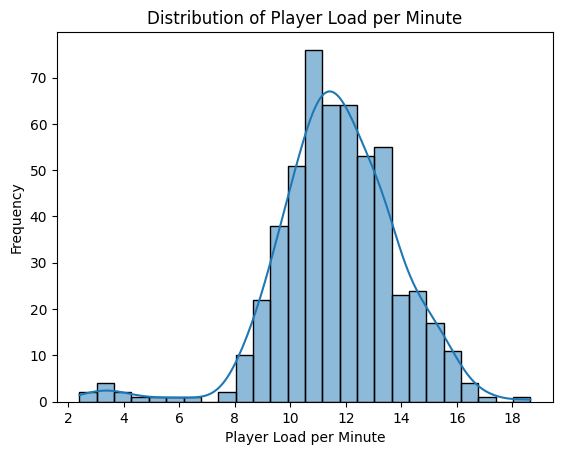

In [94]:
# Histogram and KDE of Player Load Per Minute
sns.histplot(data['Player Load Per Minute'], kde = True)

# Adding title and axis labels
plt.title("Distribution of Player Load per Minute")
plt.xlabel("Player Load per Minute")
plt.ylabel("Frequency")

# Showing Plot
plt.show()

**The distribution of Player Load Per Minute is fairly normal with a mean close to 11.5. There are some outliers, especially on the lower end**

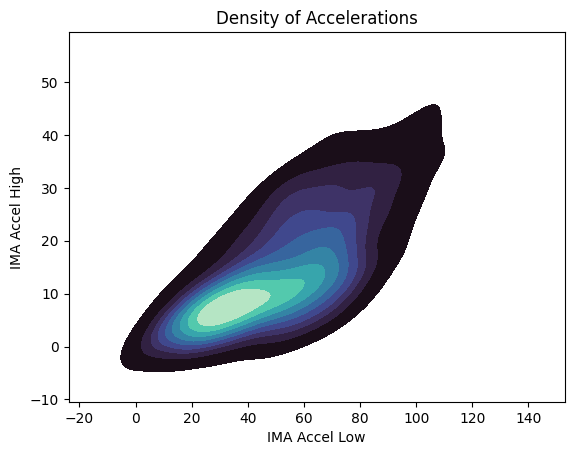

In [95]:
# 2D Kernel Density Estimate of IMA Accel Low and High
sns.kdeplot(x = 'IMA Accel Low', y = 'IMA Accel High', data = data, fill = True, cmap = 'mako')

# Adding Title
plt.title("Density of Accelerations")

# Showing plot
plt.show()

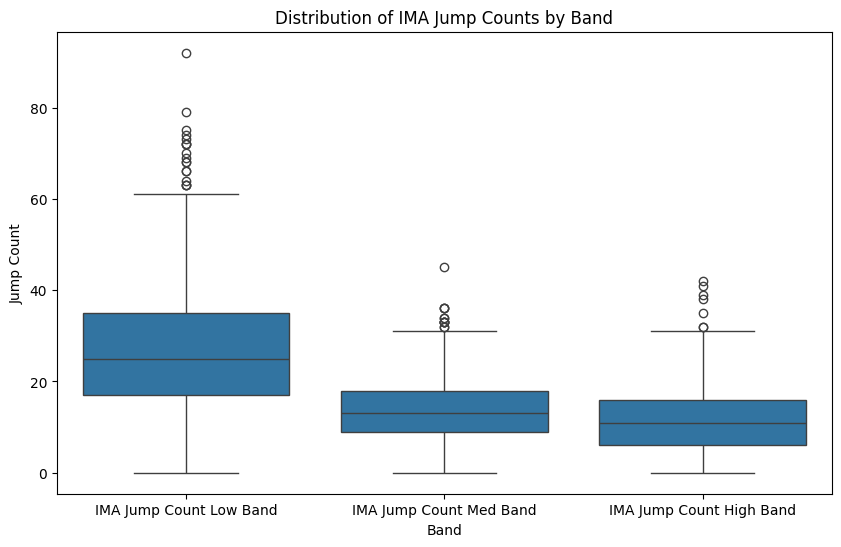

In [96]:
# Initializing Figure
plt.figure(figsize = (10, 6))

# Melting data frame
data_melted = data.melt(value_vars = ['IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band'], var_name = 'Band', value_name = 'Jump Count')

# Box Plot of Jump Counts by Band
sns.boxplot(x = 'Band', y = 'Jump Count', data = data_melted)

# Adding title
plt.title("Distribution of IMA Jump Counts by Band")
plt.xticks()

# Showing plot
plt.show()

**As we saw in the statistical description, the distribution of low band jumps has a greater median than that of the medium and high band jumps. The distributions for the medium and high band jumps appear to be fairly similar based on their box plots**

## Examine Correlations (If Relevant)

**Interpret Findings: What variables appear related?**

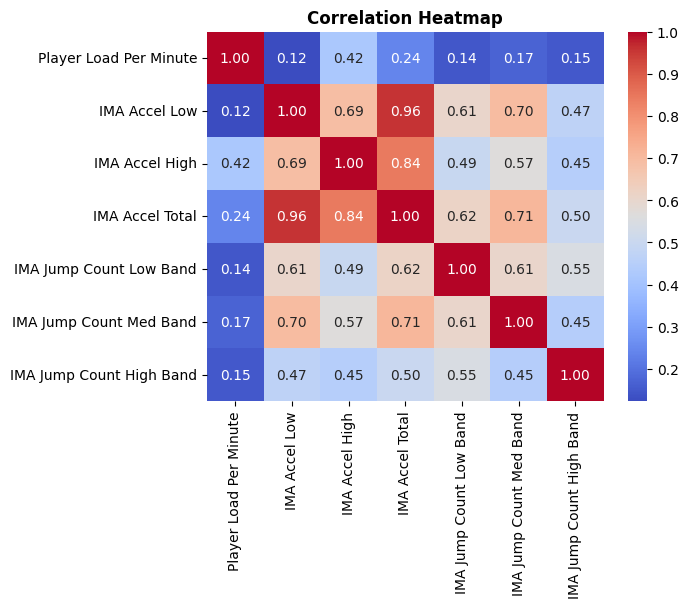

In [97]:
# Making figure
plt.figure()

# Making correlation matrix
corr_matrix = data.iloc[:, list(range(3, 10))].corr()

# Making heatmap using correlation matrix
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")

# Adding title
plt.title("Correlation Heatmap", weight = "bold", fontsize = 12)

# Showing plot
plt.show()

**Naturally, the correlations between acceleration variables and the correlations between jump variables are pretty high. Likewise, the acceleration variables correlate fairly well with the jump variables, as some jumps likely count as an acceleration. These correlations are not particularly relevant to our project, so further exploration is not necessary**

## Explore Relationship (If Relevant)

**Dig into potential causal or descriptive relationships**

**Use visualizations and statistical summaries**

In [98]:
# Getting list of unique player identifiers
data['About'].unique()

array(['Athlete A', 'Athlete C', 'Athlete D', 'Athlete F', 'Athlete G',
       'Athlete H', 'Athlete J', 'Athlete B', 'Athlete E', 'Athlete L',
       'Athlete M', 'Athlete N', 'Athlete O', 'Athlete P', 'Athlete Q',
       'Athlete R', 'Athlete S', 'Athlete T'], dtype=object)

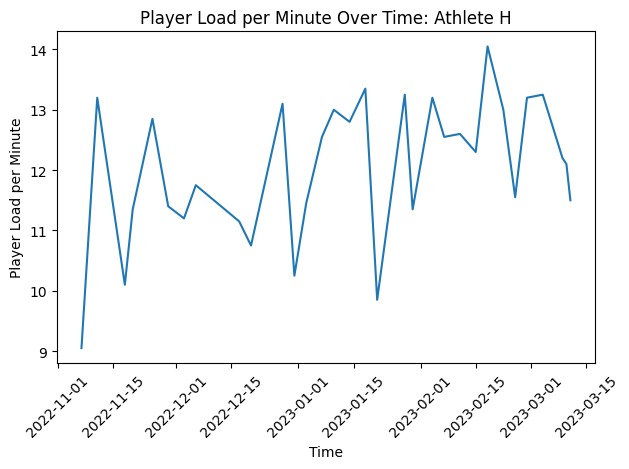

In [99]:
# Getting a specific player's data (Athlete H)
player_name = "Athlete H"
df_player = data[data['About'] == player_name]

# Sorting the player's data by date
df_player = df_player.sort_values('Date')

# Making a line plot of the Player Load Per Minute over Time
sns.lineplot(x = 'Date', y = 'Player Load Per Minute', data = df_player)

# Adding title and axis labels, rotating xticks
plt.title(f"Player Load per Minute Over Time: {player_name}")
plt.xlabel("Time")
plt.ylabel("Player Load per Minute")
plt.xticks(rotation = 45)
plt.tight_layout()

# Showing plot
plt.show()

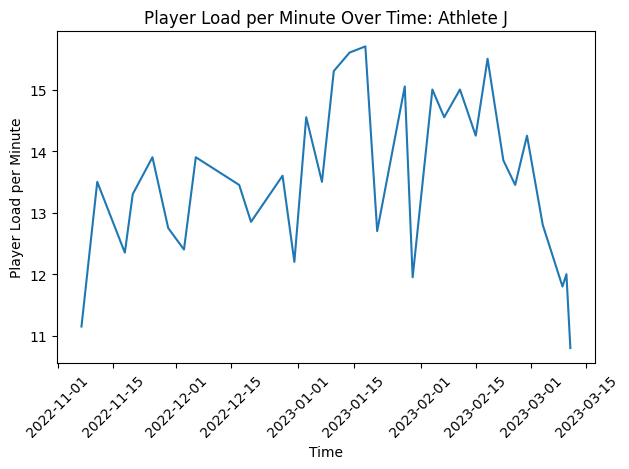

In [100]:
# Getting a specific player's data (Athlete J)
player_name = "Athlete J"
df_player = data[data['About'] == player_name]

# Sorting the player's data by date
df_player = df_player.sort_values('Date')

# Making a line plot of the Player Load Per Minute over Time
sns.lineplot(x = 'Date', y = 'Player Load Per Minute', data = df_player)

# Adding title and axis labels, rotating xticks
plt.title(f"Player Load per Minute Over Time: {player_name}")
plt.xlabel("Time")
plt.ylabel("Player Load per Minute")
plt.xticks(rotation = 45)
plt.tight_layout()

# Showing plot
plt.show()

**The two players' Player Load Per Minute line charts are fairly similar, which makes sense as they took part in the same games/scrimmages. Over the course of the season, there appears to be a gradual rise in Player Load Per Minute for both players**

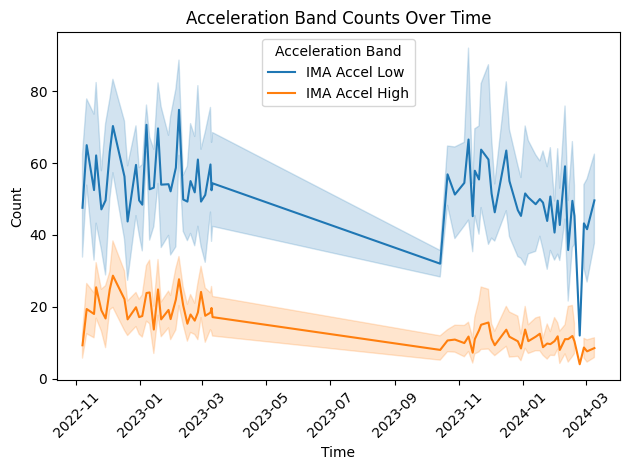

In [101]:
# Melting df
df_melted = data.melt(id_vars = 'Date', value_vars = ['IMA Accel Low', 'IMA Accel High'], var_name = 'Acceleration Band', value_name = 'Count')

# Making line plot for acceleration band counts over time
sns.lineplot(data = df_melted, x = 'Date', y = 'Count', hue = 'Acceleration Band')

# Adding title and axis labels, rotating xticks
plt.title("Acceleration Band Counts Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.tight_layout()

# Showing plot
plt.show()

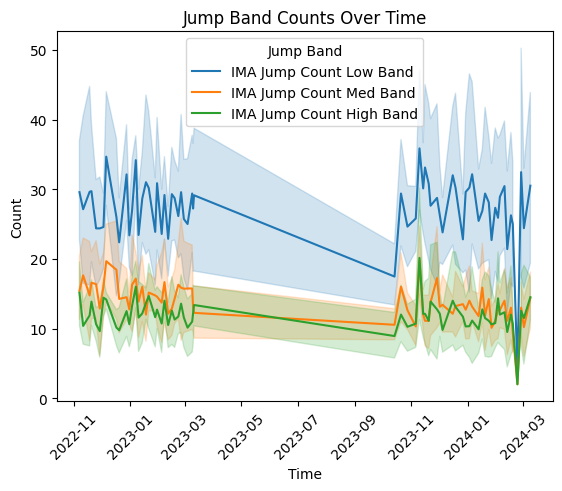

In [102]:
# Melting df
df_melted = data.melt(id_vars = 'Date', value_vars = ['IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band'], var_name = 'Jump Band', value_name = 'Count')

# Making line plot for jump band counts over time
sns.lineplot(data = df_melted, x = 'Date', y = 'Count', hue = 'Jump Band')

# Adding title and axis labels, rotating xticks
plt.title("Jump Band Counts Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.xticks(rotation = 45)

# Showing plot
plt.show()